# Raman Molmer-Sorensen


## Atomic Circuit


In [1]:
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    ParallelProtocol,  # noqa: F401
    Phonon,
    Pulse,
    SequentialProtocol,  # noqa: F401
    System,
    Transition,
)

downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 12.643e9,
    label="q1",
)
estate = Level(
    principal=6,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 811.29e12,
    label="e0",
)

transitions = [
    Transition(
        level1=downstate, level2=upstate, einsteinA=1, multipole="M1", label="q0->q1"
    ),
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
    Transition(
        level1=upstate, level2=estate, einsteinA=1, multipole="E1", label="q1->e0"
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, -1],
    levels=[downstate, upstate, estate],
    transitions=transitions,
)

Yb171_2 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 1],
    levels=[downstate, upstate, estate],
    transitions=transitions,
)

COM_x = Phonon(
    energy=2 * np.pi * 1e6, eigenvector=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2), 0, 0]
)

system = System(
    ions=[Yb171, Yb171_2],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[1],
    rabi=np.sqrt(2) * 2 * np.pi * 1e9,
    detuning=2 * np.pi * 33.195e12,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[-1, 0, 0],
    target=0,
)
beam2 = Beam(
    transition=transitions[2],
    rabi=2 * np.pi * 1e9,
    detuning=2 * np.pi * (33.195e12 - 1.01e6),
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)
beam3 = Beam(
    transition=transitions[2],
    rabi=2 * np.pi * 1e9,
    detuning=2 * np.pi * (33.195e12 + 1.01e6),
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam4 = Beam(
    transition=transitions[1],
    rabi=np.sqrt(2) * 2 * np.pi * 1e9,
    detuning=2 * np.pi * 33.195e12,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[-1, 0, 0],
    target=1,
)
beam5 = Beam(
    transition=transitions[2],
    rabi=2 * np.pi * 1e9,
    detuning=2 * np.pi * (33.195e12 - 1.01e6),
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)
beam6 = Beam(
    transition=transitions[2],
    rabi=2 * np.pi * 1e9,
    detuning=2 * np.pi * (33.195e12 + 1.01e6),
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)


protocol = ParallelProtocol(
    sequence=[
        Pulse(beam=beam, duration=4e-3),
        Pulse(beam=beam2, duration=4e-3),
        Pulse(beam=beam3, duration=4e-3),
        Pulse(beam=beam4, duration=4e-3),
        Pulse(beam=beam5, duration=4e-3),
        Pulse(beam=beam6, duration=4e-3),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [2]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("3_molmer_sorensen.json", "w") as f:
    f.write(circuit_json)

In [3]:
with open("3_molmer_sorensen.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


### Compile


In [4]:
from oqd_compiler_infrastructure import Chain, Post, Pre

from oqd_trical.backend import DynamiqsBackend, QutipBackend  # noqa: F401
from oqd_trical.light_matter.compiler.approximate import (
    AdiabaticElimination,
    FirstOrderLambDickeApprox,  # noqa: F401
    RotatingReferenceFrame,
    RotatingWaveApprox,
    SecondOrderLambDickeApprox,  # noqa: F401
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)

frame_specs = {
    "E0": [
        0,
        2 * np.pi * 12.643e9,
        2 * np.pi * (811.29e12 + 33.195e12),
    ],
    "E1": [
        0,
        2 * np.pi * 12.643e9,
        2 * np.pi * (811.29e12 + 33.195e12),
    ],
    "P0": 2 * np.pi * 1e6,
}

eliminated_specs = (2, "E0")
eliminated_specs2 = (2, "E1")

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 1e9)),
    canonicalize_emulator_circuit_factory(),
    Pre(AdiabaticElimination(eliminated_specs=eliminated_specs)),
    canonicalize_emulator_circuit_factory(),
    Pre(AdiabaticElimination(eliminated_specs=eliminated_specs2)),
    canonicalize_emulator_circuit_factory(),
    Post(FirstOrderLambDickeApprox(0.1)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

D:\work\Projects\TrICal\src\oqd_trical\light_matter\compiler\approximate.py:283: UserWarning: Caution required when using adiabatic elimination, system needs to be put in the appropriate rotating reference frame.
  warnings.warn(


In [5]:
from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(hilbert_space), "=" * 80, printer(backend.intermediate), sep="\n")

HilbertSpace
  - hilbert_space: dict
    - E0: set({0, 1})
    - E1: set({0, 1})
    - P0: set({0, 1, 2})
AtomicEmulatorCircuit
  - frame: Operator(79438311838.67151 * |1><1|_E0 @ I_E1 @ I_P0 + 79438311838.67151 * I_E0 @ |1><1|_E1 @ I_P0 + 6283185.307179586 * I_E0 @ I_E1 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(94640.53783972883 * |0><0|_E0 @ I_E1 @ I_P0 + (-3219.5402262249477 * exp(1j * (6283185.307179586 * t + -1.5707963267948966)) + -3219.5402262249477 * exp(1j * (6283185.307179586 * t + 1.5707963267948966))) * |0><0|_E0 @ I_E1 @ C_P0 + (3219.5402262249477 * exp(1j * (-6283185.307179586 * t + 1.5707963267948966)) + 3219.5402262249477 * exp(1j * (-6283185.307179586 * t + -1.5707963267948966))) * |0><0|_E0 @ I_E1 @ A_P0 + (((33460.48304080715 * exp(1j * (6346018.0 * t)) + 33460.48304080715 * exp(1j * (-6346017.0 * t))) + 33460.48304080715 * exp(1j * (6346018.0 * t))) + 33460.48304080715 * exp(1j * (-6346017.0 * t))) * |1><0|_E0 @ I_E1

### Run


In [6]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-5,
)

10.0%. Run time:   6.83s. Est. time left: 00:00:01:01


20.0%. Run time:  13.35s. Est. time left: 00:00:00:53


30.0%. Run time:  20.88s. Est. time left: 00:00:00:48


40.0%. Run time:  27.63s. Est. time left: 00:00:00:41


50.0%. Run time:  34.35s. Est. time left: 00:00:00:34


60.0%. Run time:  41.47s. Est. time left: 00:00:00:27


70.0%. Run time:  47.94s. Est. time left: 00:00:00:20


80.0%. Run time:  54.30s. Est. time left: 00:00:00:13


90.0%. Run time:  60.67s. Est. time left: 00:00:00:06


100.0%. Run time:  67.44s. Est. time left: 00:00:00:00


Total run time:  67.45s


#### Results


In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

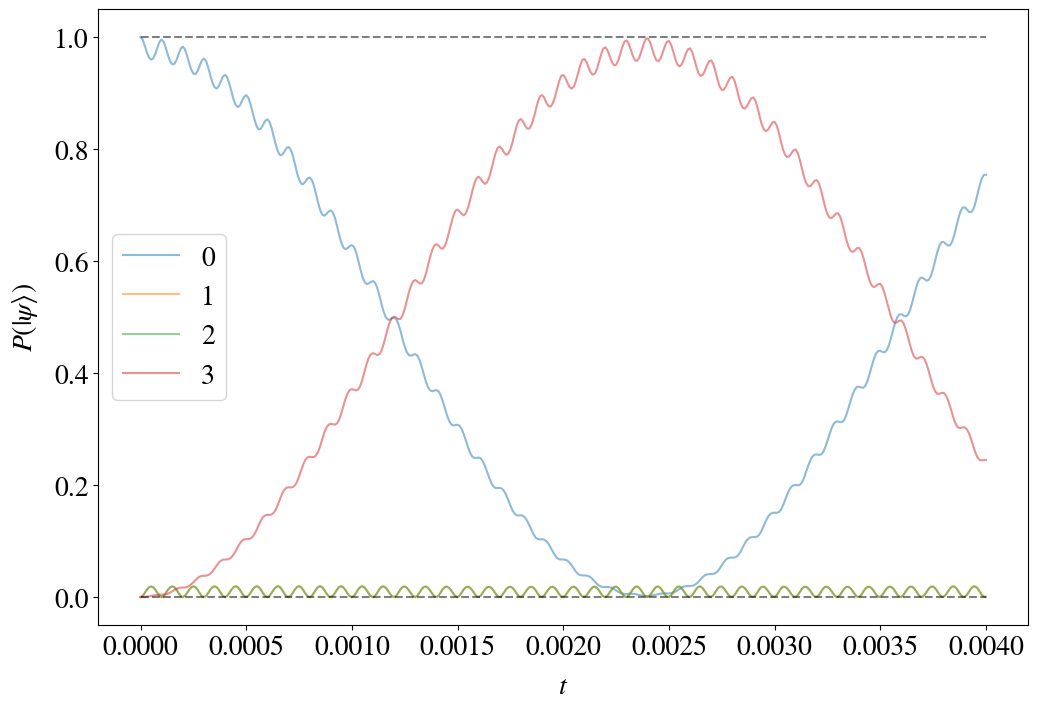

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)


state_labels = [0, 1, 2, 3]
plot_states = [
    [s.ptrace([0, 1]).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(result["tspan"][k], plot_states, label=range(len(state_labels)), alpha=0.5)

ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

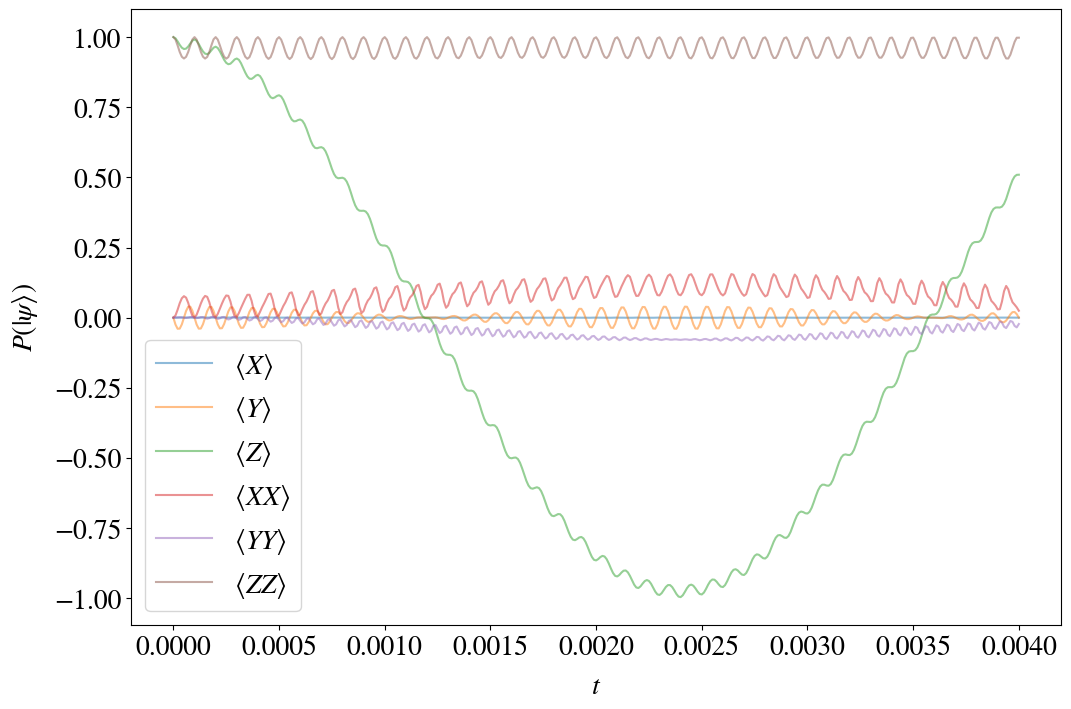

In [9]:
import qutip as qt

k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

X, Y, Z, I = qt.sigmax(), qt.sigmay(), qt.sigmaz(), qt.identity(2)  # noqa: E741


paulis = {
    "X": (qt.tensor(X, I) + qt.tensor(I, X)) / 2,
    "Y": (qt.tensor(Y, I) + qt.tensor(I, Y)) / 2,
    "Z": (qt.tensor(Z, I) + qt.tensor(I, Z)) / 2,
    "XX": qt.tensor(X, X),
    "YY": qt.tensor(Y, Y),
    "ZZ": qt.tensor(Z, Z),
}

expections = ["X", "Y", "Z", "XX", "YY", "ZZ"]

plot_states = [
    [
        qt.expect(
            paulis[o],
            s.ptrace([0, 1]),
        )
        for o in expections
    ]
    for s in result["states"][k]
]

ax.plot(
    result["tspan"][k],
    plot_states,
    label=[rf"$\langle {o}\rangle$" for o in expections],
    alpha=0.5,
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

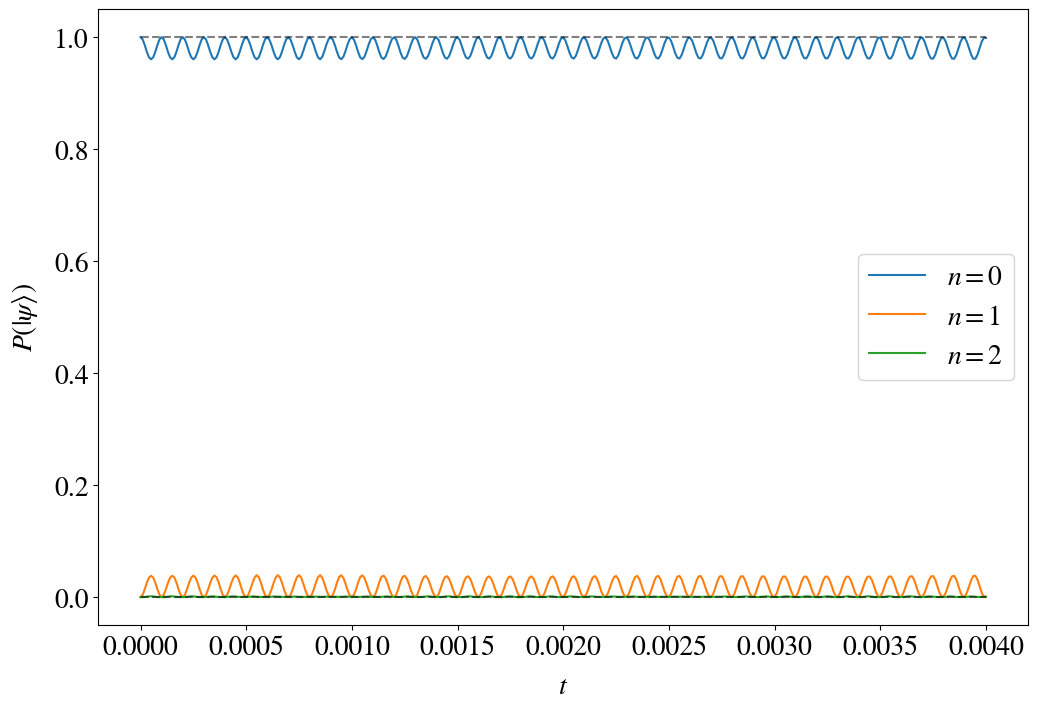

In [10]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(2).diag()[:] for s in result["states"][k]],
    label=[rf"$n={n}$" for n in range(fock_cutoff)],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()